## Targetselect for VI
Make list of targetids from a set of masks/cuts, to be used in VI.

E. Armengaud - first created 12/03/2021

In [1]:
%pylab inline
import os
from astropy.table import Table

import desispec.io
import desispec.spectra
from desitarget.targetmask import desi_mask, bgs_mask, mws_mask, scnd_mask
from desitarget.cmx.cmx_targetmask import cmx_mask
from desitarget.sv1.sv1_targetmask import desi_mask as sv1_desi_mask
from desitarget.sv1.sv1_targetmask import bgs_mask as sv1_bgs_mask
from desitarget.sv1.sv1_targetmask import mws_mask as sv1_mws_mask
from desitarget.sv1.sv1_targetmask import scnd_mask as sv1_scnd_mask
supported_desitarget_masks = {
    'DESI_TARGET': desi_mask,
    'BGS_TARGET': bgs_mask,
    'MWS_TARGET': mws_mask,
    'SECONDARY_TARGET': scnd_mask,
    'CMX_TARGET': cmx_mask,
    'SV1_DESI_TARGET': sv1_desi_mask,
    'SV1_BGS_TARGET': sv1_bgs_mask,
    'SV1_MWS_TARGET': sv1_mws_mask,
    'SV1_SECONDARY_TARGET': sv1_scnd_mask,
    }

Populating the interactive namespace from numpy and matplotlib


In [2]:
def _mask_range(array, selection_range):
    # handles selection range [a,b] or ['-',b] or [a,'-']
    if selection_range[0]=='-':
        m1 = ( array <= selection_range[1] )
    elif selection_range[1]=='-':
        m1 = ( array >= selection_range[0] )
    else:
        m1 = ( (array >= selection_range[0]) & (array <= selection_range[1]) )
    return m1

def select_targets(tileid, night, selection_criteria, targetmask_type='DESI_TARGET', with_meta=False):
    # EA - 03/2021. Small script to select a list of targetids from a selection in a given tile.
    tids_selected = []
    if with_meta: 
        meta = {'Z':[], 'DELTACHI2':[], 'ZWARN':[], 'mag_G':[], 'mag_R':[], 'mag_Z':[]}
    targetmask_used = supported_desitarget_masks[targetmask_type]
    tiledir = os.path.join(os.environ['DESI_SPECTRO_REDUX'],'cascades','tiles',tileid,night)
    petals = [str(i) for i in range(10)]

    for petal_num in petals:
        fname = os.path.join(tiledir, "coadd-"+petal_num+"-"+tileid+"-"+night+".fits")
        if not os.path.isfile(fname): continue
        spectra = desispec.io.read_spectra(fname)
        fname = fname.replace("coadd", "zbest")
        ztable = Table.read(fname, 'ZBEST')
        assert( np.all(ztable['TARGETID'] == spectra.fibermap['TARGETID']) )
        mask_sel = np.ones(len(spectra.fibermap), dtype=bool)
        # Targeting
        if 'targetmask' in selection_criteria.keys():
            m1 = ((spectra.fibermap[selection_criteria['targetmask_type']] & 
                   targetmask_used[selection_criteria['targetmask']])>0)
            mask_sel =  (m1 & mask_sel)
        # ZWARN
        if 'zwarn_value' in selection_criteria.keys():
            m1 = ( ztable['ZWARN'] == selection_criteria['zwarn_value'] )
            mask_sel =  (m1 & mask_sel)
        # DELTACHI2
        if 'deltachi2_range' in selection_criteria.keys():
            m1 = _mask_range(ztable['DELTACHI2'], selection_criteria['deltachi2_range'])
            mask_sel =  (m1 & mask_sel)
        # Z
        if 'z_range' in selection_criteria.keys():
            m1 = _mask_range(ztable['Z'], selection_criteria['z_range'])
            mask_sel =  (m1 & mask_sel)
        # Magnitudes
        for bandname in ['G', 'R', 'Z']:
            mag = np.zeros(len(spectra.fibermap))
            flux = spectra.fibermap['FLUX_'+bandname]
            extinction = np.ones(len(flux))
            if ('MW_TRANSMISSION_'+bandname) in spectra.fibermap.keys() :
                extinction = spectra.fibermap['MW_TRANSMISSION_'+bandname]
            w, = np.where( (flux>0) & (extinction>0) )
            mag[w] = -2.5*np.log10(flux[w]/extinction[w])+22.5
            vars()['mag_'+bandname] = mag
            if 'mag_'+bandname+'_range' in selection_criteria.keys():
                m1 = _mask_range(mag, selection_criteria['mag_'+bandname+'_range'])
                mask_sel =  (m1 & mask_sel)
        # Full selection except random
        wall, = np.where( mask_sel )
        tids_selected.extend(list(spectra.fibermap['TARGETID'][wall]))
        if with_meta:
            for key in ['Z', 'ZWARN', 'DELTACHI2']:
                meta[key].extend(list(ztable[key][wall]))
            for bandname in ['G', 'R', 'Z']:
                meta['mag_'+bandname].extend(list(vars()['mag_'+bandname][wall]))
    bb = ' (before rndm cut)' if 'random_number' in selection_criteria.keys() else ''
    print("Total targets filtered" + bb + ":",len(tids_selected))
    
    # Random cut
    if 'random_number' in selection_criteria.keys():
        if 'random_seed' in selection_criteria.keys():
            np.random.seed(selection_criteria['random_seed'])
        shuffled_tids = np.random.permutation(tids_selected)
        tids_meta = np.copy(tids_selected)
        tids_selected = shuffled_tids[0:selection_criteria['random_number']]
        if with_meta:
            new_meta = {'Z':[], 'DELTACHI2':[], 'ZWARN':[], 'mag_G':[], 'mag_R':[], 'mag_Z':[]}
            for tid in tids_selected:
                w, = np.where( (tids_meta==tid) )
                assert(len(w)==1)
                for key in new_meta.keys():
                    new_meta[key].append(meta[key][w[0]])
            meta = new_meta
    
    if not with_meta:
        return np.asarray(tids_selected, dtype=np.int64)
    else:
        return (np.asarray(tids_selected, dtype=np.int64), meta)
    

#### TILE 80646, BGS 


In [3]:
tileid = '80646'
night = 'deep'

selection_criteria_a = dict(    
    targetmask = 'BGS_ANY',
    targetmask_type = 'SV1_DESI_TARGET',
    zwarn_value = 0,
    deltachi2_range = [15, 80],
    z_range = ['-', 0.9],
    )
tids_selected_cut_a, meta_cut_a = select_targets(tileid, night, selection_criteria_a, with_meta=True)
np.savetxt(os.environ['HOME']+"/VI_pages/cascades/tids_"+tileid+"_BGS_cut_a.txt",tids_selected_cut_a,fmt='%.i')

selection_criteria_b = dict(    
    targetmask = 'BGS_ANY',
    targetmask_type = 'SV1_DESI_TARGET',
    zwarn_value = 0,
    deltachi2_range = [80, '-'],
    z_range = ['-', 0.9],
    random_number = 100,
    random_seed = 8064,
    )
tids_selected_cut_b, meta_cut_b = select_targets(tileid, night, selection_criteria_b, with_meta=True)
np.savetxt(os.environ['HOME']+"/VI_pages/cascades/tids_"+tileid+"_BGS_cut_b.txt",tids_selected_cut_b,fmt='%.i')

INFO:spectra.py:253:read_spectra: iotime 0.570 sec to read coadd-0-80646-deep.fits at 2021-03-15T04:11:22.548687
INFO:spectra.py:253:read_spectra: iotime 0.538 sec to read coadd-1-80646-deep.fits at 2021-03-15T04:11:23.656154
INFO:spectra.py:253:read_spectra: iotime 0.487 sec to read coadd-2-80646-deep.fits at 2021-03-15T04:11:24.591178
INFO:spectra.py:253:read_spectra: iotime 0.473 sec to read coadd-4-80646-deep.fits at 2021-03-15T04:11:25.490912
INFO:spectra.py:253:read_spectra: iotime 0.597 sec to read coadd-5-80646-deep.fits at 2021-03-15T04:11:26.591052
INFO:spectra.py:253:read_spectra: iotime 0.508 sec to read coadd-6-80646-deep.fits at 2021-03-15T04:11:27.545973
INFO:spectra.py:253:read_spectra: iotime 0.456 sec to read coadd-7-80646-deep.fits at 2021-03-15T04:11:28.460421
INFO:spectra.py:253:read_spectra: iotime 0.475 sec to read coadd-8-80646-deep.fits at 2021-03-15T04:11:29.421901
INFO:spectra.py:253:read_spectra: iotime 0.480 sec to read coadd-9-80646-deep.fits at 2021-03-15

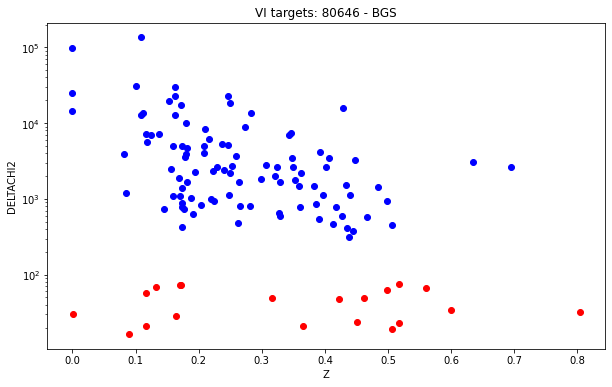

In [4]:
plt.rcParams["figure.figsize"]=10,6
plt.scatter(meta_cut_a['Z'], meta_cut_a['DELTACHI2'], c='r')
plt.scatter(meta_cut_b['Z'], meta_cut_b['DELTACHI2'], c='b')
plt.yscale('log')
plt.xlabel('Z')
plt.title('VI targets: '+tileid+' - BGS')
p = plt.ylabel('DELTACHI2')

#### TILES 80686 and 80674, LRG

In [5]:
tileid = ['80686', '80674']
night = 'deep'

tids_selected_cut_a, meta_cut_a, tids_selected_cut_b, meta_cut_b = [0,0],[0,0],[0,0],[0,0]
for i_tile in [0,1]:

    selection_criteria_a = dict(    
        targetmask = 'LRG',
        targetmask_type = 'SV1_DESI_TARGET',
        zwarn_value = 0,
        deltachi2_range = [20, 60],
        z_range = ['-', 1.4],
        )
    tids_selected_cut_a[i_tile], meta_cut_a[i_tile] = select_targets(tileid[i_tile], night, selection_criteria_a, with_meta=True)
    np.savetxt(os.environ['HOME']+"/VI_pages/cascades/tids_"+tileid[i_tile]+"_LRG_cut_a.txt",tids_selected_cut_a[i_tile],fmt='%.i')

    selection_criteria_b = dict(    
        targetmask = 'LRG',
        targetmask_type = 'SV1_DESI_TARGET',
        zwarn_value = 0,
        deltachi2_range = [60, '-'],
        z_range = ['-', 1.4],
        random_number = 100,
        random_seed = 8068,
        )
    tids_selected_cut_b[i_tile], meta_cut_b[i_tile] = select_targets(tileid[i_tile], night, selection_criteria_b, with_meta=True)
    np.savetxt(os.environ['HOME']+"/VI_pages/cascades/tids_"+tileid[i_tile]+"_LRG_cut_b.txt",tids_selected_cut_b[i_tile],fmt='%.i')

INFO:spectra.py:253:read_spectra: iotime 0.622 sec to read coadd-0-80686-deep.fits at 2021-03-15T04:12:25.102080
INFO:spectra.py:253:read_spectra: iotime 0.523 sec to read coadd-1-80686-deep.fits at 2021-03-15T04:12:26.031359
INFO:spectra.py:253:read_spectra: iotime 0.464 sec to read coadd-2-80686-deep.fits at 2021-03-15T04:12:26.940150
INFO:spectra.py:253:read_spectra: iotime 0.552 sec to read coadd-4-80686-deep.fits at 2021-03-15T04:12:27.955614
INFO:spectra.py:253:read_spectra: iotime 0.514 sec to read coadd-5-80686-deep.fits at 2021-03-15T04:12:28.930673
INFO:spectra.py:253:read_spectra: iotime 0.495 sec to read coadd-6-80686-deep.fits at 2021-03-15T04:12:29.870949
INFO:spectra.py:253:read_spectra: iotime 0.462 sec to read coadd-7-80686-deep.fits at 2021-03-15T04:12:30.769725
INFO:spectra.py:253:read_spectra: iotime 0.506 sec to read coadd-8-80686-deep.fits at 2021-03-15T04:12:31.718247
INFO:spectra.py:253:read_spectra: iotime 0.557 sec to read coadd-9-80686-deep.fits at 2021-03-15

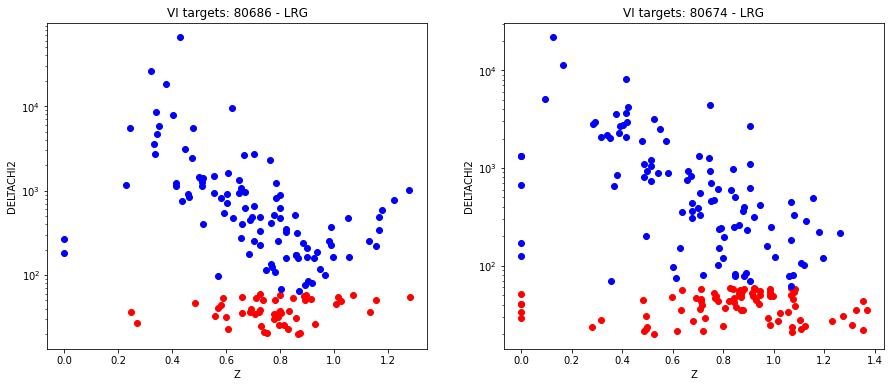

In [6]:
plt.rcParams["figure.figsize"]=15,6
fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].scatter(meta_cut_a[0]['Z'], meta_cut_a[0]['DELTACHI2'], c='r')
axs[0].scatter(meta_cut_b[0]['Z'], meta_cut_b[0]['DELTACHI2'], c='b')
axs[0].set_yscale('log')
axs[0].set_xlabel('Z')
axs[0].set_title('VI targets: '+tileid[0]+' - LRG')
axs[0].set_ylabel('DELTACHI2')
axs[1].scatter(meta_cut_a[1]['Z'], meta_cut_a[1]['DELTACHI2'], c='r')
axs[1].scatter(meta_cut_b[1]['Z'], meta_cut_b[1]['DELTACHI2'], c='b')
axs[1].set_yscale('log')
axs[1].set_xlabel('Z')
axs[1].set_title('VI targets: '+tileid[1]+' - LRG')
p = axs[1].set_ylabel('DELTACHI2')

#### TILES 80686 and 80674, QSO

In [7]:
tileid = ['80686', '80674']
night = 'deep'

tids_selected_cut_a, meta_cut_a, tids_selected_cut_b, meta_cut_b = [0,0],[0,0],[0,0],[0,0]
for i_tile in [0,1]:
    
    selection_criteria_a = dict(    
        targetmask = 'QSO',
        targetmask_type = 'SV1_DESI_TARGET',
        deltachi2_range = [20, 100],
        mag_R_range = ['-', 23.2],
        )
    tids_selected_cut_a[i_tile], meta_cut_a[i_tile] = select_targets(tileid[i_tile], night, selection_criteria_a, with_meta=True)
    np.savetxt(os.environ['HOME']+"/VI_pages/cascades/tids_"+tileid[i_tile]+"_QSO_cut_a.txt",tids_selected_cut_a[i_tile],fmt='%.i')

    selection_criteria_b = dict(    
        targetmask = 'QSO',
        targetmask_type = 'SV1_DESI_TARGET',
        deltachi2_range = [100, '-'],
        mag_R_range = ['-', 23.2],
        random_number = 100,
        random_seed = 8067,
        )
    tids_selected_cut_b[i_tile], meta_cut_b[i_tile] = select_targets(tileid[i_tile], night, selection_criteria_b, with_meta=True)
    np.savetxt(os.environ['HOME']+"/VI_pages/cascades/tids_"+tileid[i_tile]+"_QSO_cut_b.txt",tids_selected_cut_b[i_tile],fmt='%.i')

INFO:spectra.py:253:read_spectra: iotime 0.448 sec to read coadd-0-80686-deep.fits at 2021-03-15T04:13:08.910785
INFO:spectra.py:253:read_spectra: iotime 0.502 sec to read coadd-1-80686-deep.fits at 2021-03-15T04:13:09.797190
INFO:spectra.py:253:read_spectra: iotime 0.442 sec to read coadd-2-80686-deep.fits at 2021-03-15T04:13:10.649311
INFO:spectra.py:253:read_spectra: iotime 0.493 sec to read coadd-4-80686-deep.fits at 2021-03-15T04:13:11.546864
INFO:spectra.py:253:read_spectra: iotime 0.423 sec to read coadd-5-80686-deep.fits at 2021-03-15T04:13:12.344655
INFO:spectra.py:253:read_spectra: iotime 0.485 sec to read coadd-6-80686-deep.fits at 2021-03-15T04:13:13.226682
INFO:spectra.py:253:read_spectra: iotime 0.429 sec to read coadd-7-80686-deep.fits at 2021-03-15T04:13:14.166578
INFO:spectra.py:253:read_spectra: iotime 0.499 sec to read coadd-8-80686-deep.fits at 2021-03-15T04:13:15.080788
INFO:spectra.py:253:read_spectra: iotime 0.431 sec to read coadd-9-80686-deep.fits at 2021-03-15

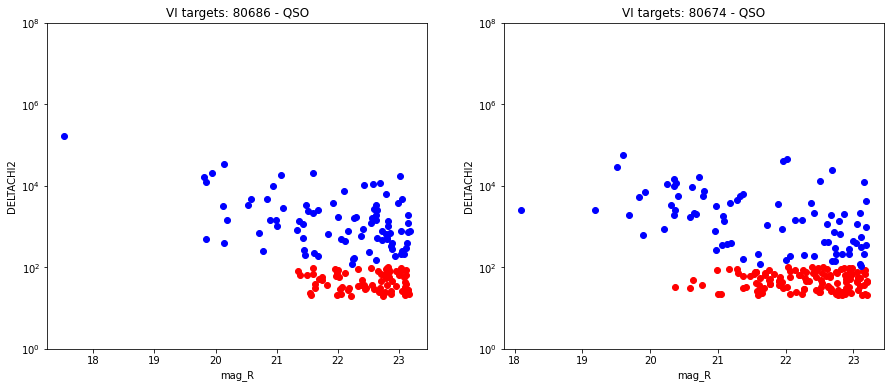

In [8]:
plt.rcParams["figure.figsize"]=15,6
fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].scatter(meta_cut_a[0]['mag_R'], meta_cut_a[0]['DELTACHI2'], c='r')
axs[0].scatter(meta_cut_b[0]['mag_R'], meta_cut_b[0]['DELTACHI2'], c='b')
axs[0].set_yscale('log')
axs[0].set_xlabel('mag_R')
axs[0].set_title('VI targets: '+tileid[0]+' - QSO')
axs[0].set_ylabel('DELTACHI2')
axs[0].set_ylim((1,1.e8)) # Hide outliers
axs[1].scatter(meta_cut_a[1]['mag_R'], meta_cut_a[1]['DELTACHI2'], c='r')
axs[1].scatter(meta_cut_b[1]['mag_R'], meta_cut_b[1]['DELTACHI2'], c='b')
axs[1].set_yscale('log')
axs[1].set_xlabel('mag_R')
axs[1].set_title('VI targets: '+tileid[1]+' - QSO')
axs[1].set_ylim((1,1.e8)) # Hide outliers
p = axs[1].set_ylabel('DELTACHI2')

In [9]:
# Outliers (no ZWARN cut)
w,=np.where(np.log10(meta_cut_b[1]['DELTACHI2']) > 80)

In [10]:
np.asarray(meta_cut_b[1]['ZWARN'])[w]

array([1570, 1570, 1570, 1570, 1570, 1570, 1570, 1570, 1570, 1570, 1570,
       1570, 1570, 1570, 1570, 1570, 1570, 1570])

In [11]:
np.asarray(meta_cut_b[1]['Z'])[w]

array([-0.0019957, -0.0019957, -0.0019957, -0.0019957, -0.0019957,
       -0.0019957, -0.0019957, -0.0019957, -0.0019957, -0.0019957,
       -0.0019957, -0.0019957, -0.0019957, -0.0019957, -0.0019957,
       -0.0019957, -0.0019957, -0.0019957])

In [12]:
w,=np.where( np.asarray(meta_cut_b[1]['Z']) < 0)

In [13]:
np.log10(meta_cut_b[1]['DELTACHI2'])[w]

array([84.28839879, 84.28839879, 84.28839879, 84.28839879, 84.28839879,
       84.28839879, 84.28839879, 84.28839879, 84.28839879, 84.28839879,
       84.28839879, 84.28839879, 84.28839879, 84.28839879, 84.28839879,
       84.28839879, 84.28839879, 84.28839879])